In [1]:
"""
File: XGBoost.ipynb
Code to train and evaluate an XGBoost model on MIMIC-IV FHIR dataset.
"""

def ProjectObjectives():
    """
    __Objectives__
    0. Import data and separate unique visit tokens
    1. Reduce the number of features (manual selection, hierarchy aggregation)
    2. Create frequency features from event tokens
    3. Include num_visits, youngest and oldest age, and maybe time
    4. Use label column to create the prediction objective
    5. Train XGBoost model and evaluate on test dataset
    >>> All objectives successful
    """
    return ProjectObjectives.__doc__

In [2]:
# Import dependencies and define useful constants
import os
import pickle

from typing import Any, List, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from scipy.sparse import csr_matrix, hstack, load_npz, save_npz, vstack

from sklearn.metrics import (
    auc,
    average_precision_score,
    balanced_accuracy_score,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm

plt.style.use("seaborn-v0_8")
%matplotlib inline

ROOT = "/fs01/home/afallah/odyssey/odyssey"
os.chdir(ROOT)

TASK = 'readmission'
NUM_PATIENTS = '50000'
DATA_ROOT = f"{ROOT}/data/bigbird_data"
DATA_PATH = f"{DATA_ROOT}/patient_sequences/patient_sequences_2048_{TASK}.parquet"
ID_PATH = f"{DATA_ROOT}/patient_id_dict/dataset_2048_{TASK}_1month.pkl"
FREQ_MATRIX_TRAIN = f"{DATA_ROOT}/patient_freq_matrix/{TASK}/patient_freq_matrix_finetune_{NUM_PATIENTS}.npz"
FREQ_MATRIX_TEST = f"{DATA_ROOT}/patient_freq_matrix/{TASK}/patient_freq_matrix_test.npz"

In [3]:
# Load dataset
dataset = pd.read_parquet(DATA_PATH)
dataset.rename(columns={f'label_{TASK}_1month': 'label'}, inplace=True)
dataset

,patient_id,num_visits,token_length,event_tokens_2048,type_tokens_2048,age_tokens_2048,time_tokens_2048,visit_tokens_2048,position_tokens_2048,last_VS_index,label
0,9b62c9f4-3fdc-5020-82b5-ae5b8292445a,2,39,[CLS] [VS] 7569 66689036430 00904224461 665530...,"[1, 2, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 8, ...","[0, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28...","[0, 5963, 5963, 5963, 5963, 5963, 5963, 5963, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",40,0
1,54ee4964-056b-5c38-a607-b95e63176fc3,17,1140,[CLS] [VS] 63323026201 00603385521 00597007575...,"[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71...","[0, 5520, 5520, 5520, 5520, 5520, 5520, 5520, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1141,1
2,02adf8a6-8bc0-55d3-81ae-4d8582094896,7,458,[CLS] [VS] 51079045420 00006494300 17714001110...,"[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, ...","[0, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65...","[0, 8002, 8002, 8002, 8002, 8002, 8002, 8002, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",459,1
3,744fe3c4-9b03-55ae-ac9f-6bc4e967cde7,1,64,[CLS] [VS] 7813 7813 7902 7902 9604 0053633810...,"[1, 2, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29...","[0, 7582, 7582, 7582, 7582, 7582, 7582, 7582, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",65,1
4,3886cafb-65f4-5789-9213-64678a202f82,2,252,[CLS] [VS] 3241 403 00904399061 00054839224 00...,"[1, 2, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76...","[0, 5670, 5670, 5670, 5670, 5670, 5670, 5670, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",253,0
...,...,...,...,...,...,...,...,...,...,...,...
75631,cf2115d7-937e-511d-b159-dd7eb3d5d420,1,108,[CLS] [VS] 66591018442 63323026201 00135019502...,"[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32...","[0, 5481, 5481, 5481, 5481, 5481, 5481, 5481, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",109,1
75632,31338a39-28f9-54a5-a810-2d05fbaa5166,2,191,[CLS] [VS] 5014 5123 00338011704 63323026201 0...,"[1, 2, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50...","[0, 4997, 4997, 4997, 4997, 4997, 4997, 4997, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",192,0
75633,0989415d-394c-5f42-8dac-75dc7306a23c,1,11,[CLS] [VS] 51079043620 51079088120 49281041550...,"[1, 2, 6, 6, 6, 6, 6, 6, 6, 3, 8, 0, 0, 0, 0, ...","[0, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 0,...","[0, 5309, 5309, 5309, 5309, 5309, 5309, 5309, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...",12,0
75634,26fb8fef-b976-5c55-859d-cc190261f94b,1,77,[CLS] [VS] 0SRD0J9 60505251903 00904224461 006...,"[1, 2, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61...","[0, 5085, 5085, 5085, 5085, 5085, 5085, 5085, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",78,0


In [4]:
patient_ids = pickle.load(open(ID_PATH, 'rb'))
train_data = dataset.loc[dataset['patient_id'].isin(patient_ids["finetune"]['few_shot'][NUM_PATIENTS])]
test_data = dataset.loc[dataset['patient_id'].isin(patient_ids['test'])]

In [5]:
# Find the unique set of all possible tokens, including special tokens
unique_event_tokens = set()

for patient_event_tokens in tqdm(
        dataset["event_tokens_2048"].values,
        desc="Loading Tokens",
        unit=" Patients",
):
    for event_token in patient_event_tokens.split(' '):
        unique_event_tokens.add(event_token)

unique_event_tokens = list(unique_event_tokens)
unique_event_tokens.sort(reverse=True)

print(
    f"Complete list of unique event tokens\nLength: {len(unique_event_tokens)}\nHead: {unique_event_tokens[:30]}...",
)

Loading Tokens: 100%|██████████| 75636/75636 [00:04<00:00, 15623.38 Patients/s]

Complete list of unique event tokens
Length: 16364
Head: ['[W_3]', '[W_2]', '[W_1]', '[W_0]', '[VS]', '[VE]', '[REG]', '[M_9]', '[M_8]', '[M_7]', '[M_6]', '[M_5]', '[M_4]', '[M_3]', '[M_2]', '[M_1]', '[M_12]', '[M_11]', '[M_10]', '[M_0]', '[LT]', '[CLS]', 'XY0VX83', 'XW0DXR5', 'XW0DX82', 'XW043C3', 'XW043B3', 'XW04351', 'XW033B3', 'XW03331']...


In [6]:
# Define the list of tokens being used as features for the XGBoost
# Note that feature 'id' will be dropped later on
special_tokens = [
    "[CLS]",
    "[PAD]",
    "[REG]",
    "[UNK]",
    "[VS]",
    "[VE]",
    "[W_0]",
    "[W_1]",
    "[W_2]",
    "[W_3]",
    *[f"[M_{i}]" for i in range(0, 13)],
    "[LT]",
]

feature_event_tokens = ["id"] + [
    token for token in unique_event_tokens if token not in special_tokens
]

print(len(feature_event_tokens), feature_event_tokens[:20])

16343 ['id', 'XY0VX83', 'XW0DXR5', 'XW0DX82', 'XW043C3', 'XW043B3', 'XW04351', 'XW033B3', 'XW03331', 'X2RF332', 'X2C1361', 'X2C0361', 'X2A5312', 'HZ87ZZZ', 'HZ85ZZZ', 'HZ2ZZZZ', 'GZB4ZZZ', 'GZB2ZZZ', 'GZB1ZZZ', 'GZB0ZZZ']


In [8]:
# Generate feature frequency matrix for each feature token in the patient data
# Since this will be saved to disk, you need only do it once
def get_patient_frequency_matrix(
        data: pd.DataFrame,
        feature_event_tokens: List[str],
        special_tokens: List[str],
        output_path: str,
        buffer_size: int = 50000) -> None:
    """ Calculate and save the patient frequency matrix. """

    patient_freq_matrix = None
    matrix_buffer = []

    for idx, patient in tqdm(data.iterrows(), desc="Loading Tokens", unit=" Patients", total=len(data)):
        patient_history = {token: 0 for token in feature_event_tokens}
        patient_history["id"] = idx

        for event_token in patient["event_tokens_2048"].split(' '):
            if event_token not in special_tokens:
                patient_history[event_token] += 1

        matrix_buffer.append(list(patient_history.values()))

        if len(matrix_buffer) >= buffer_size:
            current_matrix = csr_matrix(
                matrix_buffer, shape=(len(matrix_buffer), len(feature_event_tokens)),
            )

            if patient_freq_matrix is None:
                patient_freq_matrix = current_matrix
            else:
                patient_freq_matrix = vstack(
                    [patient_freq_matrix, current_matrix], format="csr",
                )

            matrix_buffer = []


    if matrix_buffer:
        current_matrix = csr_matrix(
            matrix_buffer, shape=(len(matrix_buffer), len(feature_event_tokens)),
        )

        if patient_freq_matrix is None:
            patient_freq_matrix = current_matrix
        else:
            patient_freq_matrix = vstack(
                [patient_freq_matrix, current_matrix], format="csr",
            )

    save_npz(output_path, patient_freq_matrix)
    print(f"Save & Done! Final Matrix Shape: {patient_freq_matrix.shape}")

get_patient_frequency_matrix(train_data, feature_event_tokens, special_tokens, output_path=FREQ_MATRIX_TRAIN)
get_patient_frequency_matrix(test_data, feature_event_tokens, special_tokens, output_path=FREQ_MATRIX_TEST)

Loading Tokens: 100%|██████████| 50000/50000 [02:37<00:00, 318.29 Patients/s]


Save & Done! Final Matrix Shape: (50000, 16343)


Loading Tokens: 100%|██████████| 10000/10000 [00:19<00:00, 500.77 Patients/s]


Save & Done! Final Matrix Shape: (10000, 16343)


In [9]:
# Load feature frequency matrix from disk, generated by above code cell
patient_freq_matrix = load_npz(FREQ_MATRIX_TRAIN)
patient_freq_matrix_test = load_npz(FREQ_MATRIX_TEST)
num_patients = patient_freq_matrix.shape[0] + patient_freq_matrix_test.shape[0]
patient_freq_matrix

<50000x16343 sparse matrix of type '<class 'numpy.int64'>'
	with 6072798 stored elements in Compressed Sparse Row format>

In [10]:
def find_min_greater_than_zero(lst: List[int]) -> int:
    """Return the minimum positive number in the given list"""
    positive_numbers = np.array(lst)[np.array(lst) > 0]

    if len(positive_numbers) == 0:
        return 0

    min_positive = np.min(positive_numbers)
    return min_positive

In [11]:
# Get extra features such as number of visits and age
def add_age_to_freq_matrix(data: pd.DataFrame, patient_freq_matrix: np.ndarray) -> np.ndarray:
    """ Add age feature to patient frequency matrix. """

    num_visits = data["num_visits"].values
    min_age = [
        find_min_greater_than_zero(patient_age_tokens)
        for patient_age_tokens in data["age_tokens_2048"]
    ]
    max_age = [np.max(patient_age_tokens) for patient_age_tokens in data["age_tokens_2048"]]

    # Add extra features to the frequency dataset
    patient_freq_matrix = hstack(
        [patient_freq_matrix, csr_matrix([num_visits, min_age, max_age]).T], format="csr",
    )
    return patient_freq_matrix[:, 1:]  # Drop id feature

patient_freq_matrix = add_age_to_freq_matrix(train_data, patient_freq_matrix)
patient_freq_matrix_test = add_age_to_freq_matrix(test_data, patient_freq_matrix_test)

In [12]:
# Get intuition about the frequency of different features in the training dataset
report_threshold = 1
features_above_threshold = np.sum(
    (patient_freq_matrix.getnnz(axis=0) >= report_threshold).astype(int),
)

print(f"How many features have been reported for at least {report_threshold} patients?\n"
      f"{features_above_threshold} Features")

# Plot the histogram of feature frequency
# plt.hist(patient_freq_matrix.getnnz(axis=0), bins=range(num_patients+1), edgecolor='black')
# plt.xlabel('Number of Nonzero Rows')
# plt.ylabel('Number of Columns')
# plt.title('Histogram of Nonzero Rows per Column')
# plt.show()

How many features have been reported for at least 1 patients?
14817 Features


In [13]:
# Pick features to train the model on
NUM_FEATURES = 20000
features_sorted_by_freq = np.argsort(-patient_freq_matrix.getnnz(axis=0))
selected_features = features_sorted_by_freq[: NUM_FEATURES + 1]
selected_features

array([16342, 16344, 16343, ..., 13321,  8589,  9410])

In [14]:
# Define custom labels, here death in 12 M, not needed if dataset already has labels
# data["label"] = (
#     (data["death_after_end"] >= 0) & (data["death_after_end"] <= 31)
# ).astype(int)
#
# print(f"Total positive labels: {sum(data['label'])} out of {len(data)}")

In [15]:
# Prepare data for model training
X = vstack([patient_freq_matrix, patient_freq_matrix_test])
Y = np.hstack([train_data["label"].values, test_data["label"].values])

# Optional, Scale features. Didn't improve performance
# scaler = MaxAbsScaler()
# X = scaler.fit_transform(X)

# Optional, Split data into train and test sets if dataset is not already split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, Y, test_size=0.2, stratify=Y, random_state=1
# )

In [16]:
# Split data into train and test based on original dataset definitions
X_train = patient_freq_matrix
X_test = patient_freq_matrix_test

y_train = train_data["label"].values
y_test = test_data["label"].values

In [17]:
# Calculate class weights to scale positive weights
total_negative = len(y_train) - sum(y_train)
total_positive = sum(y_train)
scale_pos_weight = total_negative / (total_positive // 1)    # 1.5 for two_weeks and 4 for one_month | use sqrt if extremely imbalanced

# Single XGBoost Classifier
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=23, scale_pos_weight=scale_pos_weight)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=23, ...)

Balanced Accuracy
Train: 0.77158  |  Test: 0.62479  |  All Data: 0.74721

F1 Score
Train: 0.75880  |  Test: 0.55057  |  All Data: 0.72839

Precision
Train: 0.80377  |  Test: 0.52883  |  All Data: 0.76014

Recall
Train: 0.71860  |  Test: 0.57419  |  All Data: 0.69919

AUROC
Train: 0.77158  |  Test: 0.62479  |  All Data: 0.74721

AUC-PR
Train: 0.83153  |  Test: 0.63416  |  All Data: 0.80207

Average Precision Score
Train: 0.71829  |  Test: 0.46895  |  All Data: 0.67629


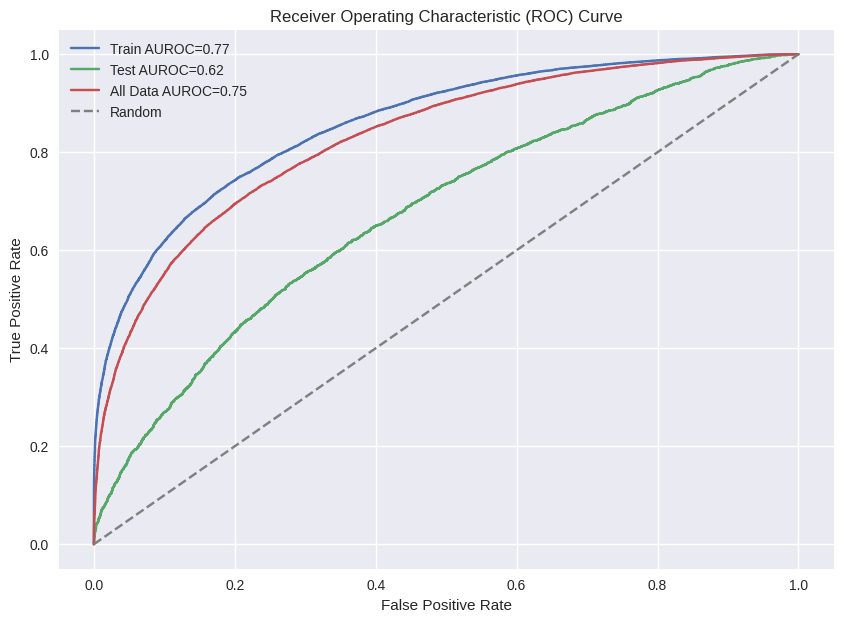

In [18]:
### ASSESS MODEL PERFORMANCE ###

# Predict labels for train, test, and all data
y_train_pred = xgb_model.predict(X_train)
y_train_prob = xgb_model.predict_proba(X_train)[:, 1]

y_test_pred = xgb_model.predict(X_test)
y_test_prob = xgb_model.predict_proba(X_test)[:, 1]

all_data_pred = xgb_model.predict(X)
all_data_prob = xgb_model.predict_proba(X)[:, 1]

# Balanced Accuracy
y_train_accuracy = balanced_accuracy_score(y_train, y_train_pred)
y_test_accuracy = balanced_accuracy_score(y_test, y_test_pred)
all_data_accuracy = balanced_accuracy_score(Y, all_data_pred)

# F1 Score
y_train_f1 = f1_score(y_train, y_train_pred)
y_test_f1 = f1_score(y_test, y_test_pred)
all_data_f1 = f1_score(Y, all_data_pred)

# Precision
y_train_precision = precision_score(y_train, y_train_pred)
y_test_precision = precision_score(y_test, y_test_pred)
all_data_precision = precision_score(Y, all_data_pred)

# Recall
y_train_recall = recall_score(y_train, y_train_pred)
y_test_recall = recall_score(y_test, y_test_pred)
all_data_recall = recall_score(Y, all_data_pred)

# AUROC
y_train_auroc = roc_auc_score(y_train, y_train_pred)
y_test_auroc = roc_auc_score(y_test, y_test_pred)
all_data_auroc = roc_auc_score(Y, all_data_pred)

# AUC-PR (Area Under the Precision-Recall Curve)
y_train_p, y_train_r, _ = precision_recall_curve(y_train, y_train_pred)
y_test_p, y_test_r, _ = precision_recall_curve(y_test, y_test_pred)
all_data_p, all_data_r, _ = precision_recall_curve(Y, all_data_pred)

y_train_auc_pr = auc(y_train_r, y_train_p)
y_test_auc_pr = auc(y_test_r, y_test_p)
all_data_auc_pr = auc(all_data_r, all_data_p)

# Average Precision Score (APS)
y_train_aps = average_precision_score(y_train, y_train_pred)
y_test_aps = average_precision_score(y_test, y_test_pred)
all_data_aps = average_precision_score(Y, all_data_pred)

# Print Metrics
print(
    f"Balanced Accuracy\nTrain: {y_train_accuracy:.5f}  |  Test: {y_test_accuracy:.5f}  |  All Data: {all_data_accuracy:.5f}\n",
)
print(
    f"F1 Score\nTrain: {y_train_f1:.5f}  |  Test: {y_test_f1:.5f}  |  All Data: {all_data_f1:.5f}\n",
)
print(
    f"Precision\nTrain: {y_train_precision:.5f}  |  Test: {y_test_precision:.5f}  |  All Data: {all_data_precision:.5f}\n",
)
print(
    f"Recall\nTrain: {y_train_recall:.5f}  |  Test: {y_test_recall:.5f}  |  All Data: {all_data_recall:.5f}\n",
)
print(
    f"AUROC\nTrain: {y_train_auroc:.5f}  |  Test: {y_test_auroc:.5f}  |  All Data: {all_data_auroc:.5f}\n",
)
print(
    f"AUC-PR\nTrain: {y_train_auc_pr:.5f}  |  Test: {y_test_auc_pr:.5f}  |  All Data: {all_data_auc_pr:.5f}\n",
)
print(
    f"Average Precision Score\nTrain: {y_train_aps:.5f}  |  Test: {y_test_aps:.5f}  |  All Data: {all_data_aps:.5f}\n",
)

# Plot ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
fpr_all_data, tpr_all_data, _ = roc_curve(Y, all_data_prob)

# Plot Information
plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, label=f"Train AUROC={y_train_auroc:.2f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUROC={y_test_auroc:.2f}")
plt.plot(fpr_all_data, tpr_all_data, label=f"All Data AUROC={all_data_auroc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

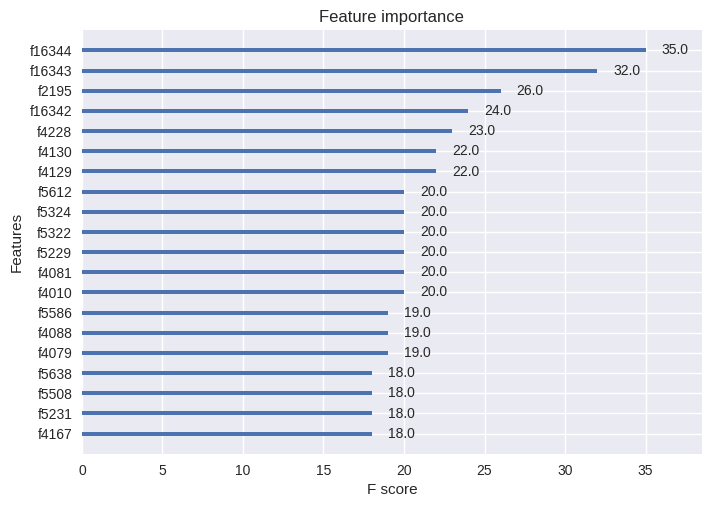

In [19]:
xgb.plot_importance(xgb_model, max_num_features=20)
plt.show()

In [53]:
# CAREFUL, one needs to match feature ids to actual FHIR features before interpretation
# Assess which features are the most important

# Get feature importances
feature_importances = xgb_model.feature_importances_

# Create a list of tuples (feature, importance) and sort it by importance in descending order
sorted_importances = sorted(zip(selected_features, feature_importances), key=lambda x: x[1], reverse=True)

# Display the top 10 most important features
top_features = sorted_importances[:10]
for feature, importance in top_features:
    print(f"{feature}: {importance}")

1042: 0.07624141871929169
335: 0.02400890924036503
10389: 0.022540519014000893
19414: 0.017375478520989418
16830: 0.016997143626213074
15307: 0.0141630033031106
4580: 0.011970368213951588
9354: 0.011044329032301903
3957: 0.01013939268887043
4915: 0.00976595375686884


In [ ]:
# Save current predictions, labels, and probabilities to disk
np.save(f"{ROOT}/xgboost_y_test_pred_two_weeks.npy", y_test_pred)
np.save(f"{ROOT}/xgboost_y_test_pred_two_weeks_labels.npy", y_test)
np.save(f"{ROOT}/xgboost_y_test_pred_two_weeks_prob.npy", xgb_model.predict_proba(X_test))

In [ ]:
### SCRIPT FOR K-FOLD VALIDATION ###
N_FOLDS = 10

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=23)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
f1_scores = []
precisions = []
recalls = []
aurocs = []
auc_prs = []
average_precision_scores = []

# Perform k-fold cross-validation
for train_index, test_index in tqdm(
        stratified_kfold.split(X, Y),
        desc=f"{N_FOLDS}-Fold Validation",
        unit=" Model(s)",
):
    # Get the relevant train and test data
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = Y[train_index], Y[test_index]

    # Create a new XGBoost model for each fold
    xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=23, scale_pos_weight=scale_pos_weight)

    # Train the model on the training fold
    xgb_model.fit(X_train_fold, y_train_fold)

    # Predict on the test fold
    y_pred_fold = xgb_model.predict(X_test_fold)

    # Calculate performance metrics
    accuracy_fold = balanced_accuracy_score(y_test_fold, y_pred_fold)
    f1_fold = f1_score(y_test_fold, y_pred_fold)
    precision_fold = precision_score(y_test_fold, y_pred_fold)
    recall_fold = recall_score(y_test_fold, y_pred_fold)
    auroc_fold = roc_auc_score(y_test_fold, y_pred_fold)
    p_fold, r_fold, _ = precision_recall_curve(y_test_fold, y_pred_fold)
    auc_pr_fold = auc(r_fold, p_fold)
    average_precision_score_fold = average_precision_score(y_test_fold, y_pred_fold)

    # Append metrics to lists
    accuracy_scores.append(accuracy_fold)
    f1_scores.append(f1_fold)
    precisions.append(precision_fold)
    recalls.append(recall_fold)
    aurocs.append(auroc_fold)
    auc_prs.append(auc_pr_fold)
    average_precision_scores.append(average_precision_score_fold)

# Print average metrics across all folds
print(f"Average Balanced Accuracy: {sum(accuracy_scores) / N_FOLDS:.5f}")
print(f"Average F1 Score: {sum(f1_scores) / N_FOLDS:.5f}")
print(f"Average Precision: {sum(precisions) / N_FOLDS:.5f}")
print(f"Average Recall: {sum(recalls) / N_FOLDS:.5f}")
print(f"Average AUROC: {sum(aurocs) / N_FOLDS:.5f}")
print(f"Average AUC-PR: {sum(auc_prs) / N_FOLDS:.5f}")
print(f"Average Precision Score: {sum(average_precision_scores) / N_FOLDS:.5f}")

In [ ]:
# # Generate labels for the dataset if necessary
# labes_for_given_token = []; given_token = '8135'; de = []
#
# for idx, patient in tqdm(dataset.iterrows(), desc="Loading Tokens", unit=" Patients"):
#     if given_token in list(patient['event_tokens_2048'].split(' ')):
#         # print(patient); break
#         de.append(patient['label'])
#
# print(f"Total Occurrences: {len(labes_for_given_token)}, Positive Labels: {sum(labes_for_given_token)}")